# Standard Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import torch
import torch.nn as nn

# Constants
Listed below is the persistent seed I am choosing to use for this project along with some code to set it in all its instances. There is also some code for some standard column names that will be used many times in this project.

In [35]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

catechins = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate']
chemicals = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate', 'Caffeine']
sensory_evaluations = ['Taste','Appearance','Aroma','Liqour color','Infused leaf']

# Import data
This data is collected from a wide range of academic articles which bulk work consists of tea-catechins or sensory appeal.

In [36]:
# Chemical and Instrumental Assessment of Green Tea Sensory Preference - Y.R. Liang, Q. Ye, J. Jin, H. Liang, J.L. Lu, Y.Y. Du & J.J. Dong
# https://doi.org/10.1080/10942910701299430
# Notes: downloaded CSVs

df_10942910701299430 = pd.read_csv('../data/10942910701299430/chemical_composition.csv', header=1)
df_10942910701299430 = pd.concat([df_10942910701299430, pd.read_csv('../data/10942910701299430/sensory_evaluation.csv')], axis=1)

# Phytochemical Composition and Antioxidant Capacity of 30 Chinese Teas - by Guo-Yi Tang, Cai-Ning Zhao, Xiao-Yu Xu, Ren-You Gan, Shi-Yu Cao, Qing Liu, AoShang, Qian-Qian Mao & Hua-Bin Li
# https://doi.org/10.3390/antiox8060180
# Notes: Manually scraped data

df_antiox8060180 = pd.read_csv('../data/antiox8060180/chemical_composition.csv')

# Catechin and caffeine content of tea (Camellia sinensis L.) leaf significantly differ with seasonal variation... - Himangshu Deka, Tupu Barman, Jintu Dutta, Arundhuti Devi, Pradip Tamuly, Ranjit Kumar Paul & Tanmoy Karak 
# https://doi.org/10.1016/j.jfca.2020.103684
# https://krishi.icar.gov.in/jspui/bitstream/123456789/68751/2/S0889157520313892-main.pdf - Free access

# df_j.jfca.2020.103684_chemical_composition = pd.read_csv('dava/j.jfca.2020.103684/chemical_composition.csv')

# Comparative analysis of tea catechins and theaflavins by high-performance liquid chromatography and capillary electrophoresis - Bee-Lan Lee & Choon-Nam Ong
# https://doi.org/10.1016/S0021-9673(00)00215-6
# Notes: Manually scraped data

df_S0021967300002156 = pd.read_csv('../data/S0021967300002156/chemical_composition.csv')

# Survey of Catechins, Gallic Acid, and Methylxanthines in Green, Oolong, Pu-erh, and Black Teas - Jen-Kun Lin, Chih-Li Lin, Yu-Chih Liang, Shoei-Yn Lin-Shiau & I-Ming Juan
# https://doi.org/10.1021/jf980223x
# Notes: Manually scraped data

df_jf980223x = pd.read_csv('../data/jf980223x/chemical_composition.csv')

# Analysis of some selected catechins and caffeine in green tea by high performance liquid chromatography
# https://doi.org/10.1016/j.foodchem.2012.03.039
# Notes: Manually scraped data

df_jfoodchem201203039 = pd.read_csv('../data/jfoodchem201203039/chemical_composition.csv', on_bad_lines='skip')

# Catechin content of 18 teas and a green tea extract supplement correlates with the antioxidant capacity 
# https://doi.org/10.1207/S15327914NC4502_13
# Notes: Manually scraped data

df_15327914NC4502_13 = pd.read_csv('../data/15327914NC4502_13/chemical_composition.csv')

# Catechin contents in tea (Camellia sinensis) as affected by cultivar and environment and their relation to chlorophyll contents
# https://doi.org/10.1016/j.foodchem.2010.08.029
# Notes: Manually scraped data

df_jfoodchem201008029 = pd.read_csv('../data/jfoodchem201008029/chemical_composition.csv')

# Analysis of Catechin Content of Commercial Green Tea Products
# https://doi.org/10.1080/J157v03n03_03
# Notes: Manually scraped data

df_J157v03n03_03 = pd.read_csv('../data/J157v03n03_03/chemical_composition.csv')

# Phenol-Explorer database scraping
# phenol-explorer.eu
# Notes: Manually scraped data

df_phenol_explorer = pd.read_csv('../data/phenol_explorer/chemical_composition.csv')

In [37]:
# List of all imported dataframes
all_dataframes = [df_10942910701299430,
                  df_antiox8060180,
                  df_S0021967300002156,
                  df_jf980223x,
                  df_jfoodchem201203039,
                  df_15327914NC4502_13,
                  df_phenol_explorer]

# Combine data

To combine the data I am going to create a data pipeline that does the following:

1. Add all the pandas dataframes to a list.
2. Read that list into a function.
3. The function reads an individual dataframe from that list then resets the index, rename catechins to be like the catechin dictionary below, drop unused columns, add columns that are part of the standardized column format, and then sorts the columns to be part of the standardized column format.
4. The function will then add the dataframe to a list denoting it is processed.
5. Once the function has processed all the dataframes in the lists it will loop through the data frames in the finished list and concatenate them.
6. The function will return a combined dataframe.

## Data Frame Format

The data frames will be combined into the following format:

- `'Catechin'`
- `'Epicatechin'`
- `'Gallocatechin'`
- `'Epigallocatechin'`
- `'Catechin Gallate'`
- `'Epicatechin Gallate'`
- `'Gallocatechin Gallate'`
- `'Epigallocatechin Gallate'`
- `'Gallic Acid'`
- `'Chlorogenic Acid'`
- `'Caffeine'`
- `'Taste'`
- `'Appearance'`
- `'Aroma'`
- `'Liqour color'`


In [38]:
catechin_dictionary = {
    'C': 'Catechin',
    'EC': 'Epicatechin',
    'GC': 'Gallocatechin',
    'EGC': 'Epigallocatechin',
    'CG': 'Catechin Gallate',
    'ECG': 'Epicatechin Gallate',
    'GCG': 'Gallocatechin Gallate',
    'EGCG': 'Epigallocatechin Gallate'
}

standardized_columns = [
    'Catechin',
    'Epicatechin',
    'Gallocatechin',
    'Epigallocatechin',
    'Catechin Gallate',
    'Epicatechin Gallate',
    'Gallocatechin Gallate',
    'Epigallocatechin Gallate',
    'Caffeine',
    'Taste',
    'Appearance',
    'Aroma',
    'Liqour color',
    'Infused leaf'
]

To faciliate scability I am create a sklearn pipeline and process all my data to be concatenated.
First I will define the functions that will go into my data preprocessing pipeline.

In [39]:
def reset_index(dataframe: pd.DataFrame):
    return dataframe.reset_index(drop=1)

def rename_columns(dataframe: pd.DataFrame):
    return dataframe.rename(columns=catechin_dictionary)

def drop_nonstandardized_columns(dataframe: pd.DataFrame):
    return dataframe.drop(columns=[column for column in dataframe if column not in standardized_columns])

def reformat_columns(dataframe: pd.DataFrame):
    return dataframe.reindex(columns=standardized_columns)

def remove_standard_deviation_format(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        if (dataframe[column].dtype.name == 'object') or (dataframe[column].dtype.name == 'string'):
            dataframe[column] = dataframe[column].str.replace('± \d*.\d*', '', regex=True)
    return dataframe    

Next, the data pipeline applies all of those functions to the inputed dataset.

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ResetIndexTransformer = FunctionTransformer(reset_index)
RenameColumnsTransformer = FunctionTransformer(rename_columns)
DropNonstandardizedColumnsTransformer = FunctionTransformer(drop_nonstandardized_columns)
ReformatColumnsTransformer = FunctionTransformer(reformat_columns)
RemoveStandardDeviationFormat = FunctionTransformer(remove_standard_deviation_format)

data_combining_pipeline = make_pipeline(
    ResetIndexTransformer,
    RenameColumnsTransformer,
    DropNonstandardizedColumnsTransformer,
    ReformatColumnsTransformer,
    RemoveStandardDeviationFormat
)

Now I am creating a pipeline that transforms each dataframe then concatenates it and returns one dataframe to be used for the model.

In [41]:
def process_dataframes(dataframes: list):
    processed_dataframes = []
    for dataframe in dataframes:
        dataframe = data_combining_pipeline.fit_transform(dataframe)
        processed_dataframes.append(dataframe)
    return processed_dataframes

def concatenate_dataframes(dataframes: list):
    formated_dataframe = pd.concat(dataframes, ignore_index=True)
    return formated_dataframe

def change_dtypes(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    return dataframe

In [42]:
ProcessDataframes = FunctionTransformer(process_dataframes)
ConcatenateDataframes = FunctionTransformer(concatenate_dataframes)
Change_Dtypes = FunctionTransformer(change_dtypes)

data_combining_pipeline_processor = make_pipeline(
    ProcessDataframes,
    ConcatenateDataframes,
    Change_Dtypes
)

In [43]:
df = data_combining_pipeline_processor.transform(all_dataframes)
df.head()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,8.93,7.04,8.36,18.00,3.72,4.66,21.50,21.11,31.47,23.1,7.9,23.1,8.1,15.2
1,9.87,NaN,22.55,10.92,5.33,5.29,26.62,23.42,39.24,25.8,8.1,24.9,8.3,16.4
2,6.37,4.92,21.87,10.98,5.29,5.43,24.84,23.63,41.08,23.7,7.8,23.7,7.6,15.8
3,6.78,5.91,23.08,11.47,5.76,6.43,25.34,22.14,50.97,23.7,8.3,24.0,8.6,16.6
4,5.82,5.60,24.12,13.35,5.28,5.94,27.92,25.09,53.70,24.6,8.2,26.4,8.5,16.6


# Remove Extraneous Data
It is common for this aggregated dataset to come with columns that contain no data at all, that will be removed here.

In [44]:
df = df.dropna(how='all', axis=0)

# Data Explanation

The data we will be examining and training on is purely numerical. This has many advantages in terms of cleaning and training but a few disadvantages that may not be readily appearant. The catechins and caffeine are all listed in milligrams. What is taste, appearance, aroma, and liquor color measured in? Milligrams? No, instead it is much more complicated. Thankfully this is a pretty standardized tea tasting scoring system throughout China so most of our data will reflect that, any data that does not reflect that will be modified into this scoring system. The scoring system is outlined below:

# Tea Evaluation Scoring System

The scoring system for tea evaluation assigns scores to tea samples based on several attributes, with a maximum possible score of 100. Each attribute contributes a certain percentage to the total score, reflecting its significance in the overall quality of the tea.

## Breakdown of Scores by Categories

- **Dry Tea Appearance (10%)**
  - Observations include the look of the tea leaves when dry, focusing on color, size, tenderness, and how well the leaves are twisted.

- **Aroma (30%)**
  - This category assesses the scent of the tea, a crucial indicator of its flavor profile.

- **Liquor Color (10%)**
  - The color of the tea once it's brewed is evaluated, providing insights into its strength and quality.

- **Taste (30%)**
  - The flavor of the tea is the most weighted aspect, reflecting its overall palatability and richness.

- **Infused Leaf (20%)**
  - After brewing, the tea leaves are examined again for color, size, tenderness, and evenness, indicating the quality of the tea.

## Testing Process

### 1. Dry Tea Appearance
- Place 200 grams of dry tea on a 20cm x 20cm wooden tray.
- Score based on visual qualities like color, size, and evenness.

### 2. Preparing the Tea
- Brew 3 grams of tea in 150 milliliters of boiling water for 5 minutes to test aroma, liquor color, and taste.

### 3. Tasting and Scoring
- Pour the brewed tea into a special tasting bowl.
- Compare with three reference samples for aroma, color, and taste to assign scores.

### 4. Infused Leaf
- Place the brewed leaves in a porcelain tray with cold water.
- Score based on post-brew visual attributes like color and tenderness.

This methodical approach ensures each tea sample is thoroughly evaluated on its physical and sensory qualities, providing a comprehensive understanding of its overall quality.



# Exploratory Data Analysis

This pairplot offers a high-level visualization of what is going on internally in the dataset. Next, we will examine further the intricacies of the data before cleaning it further and imputing data using a Generative Adversarial Network.

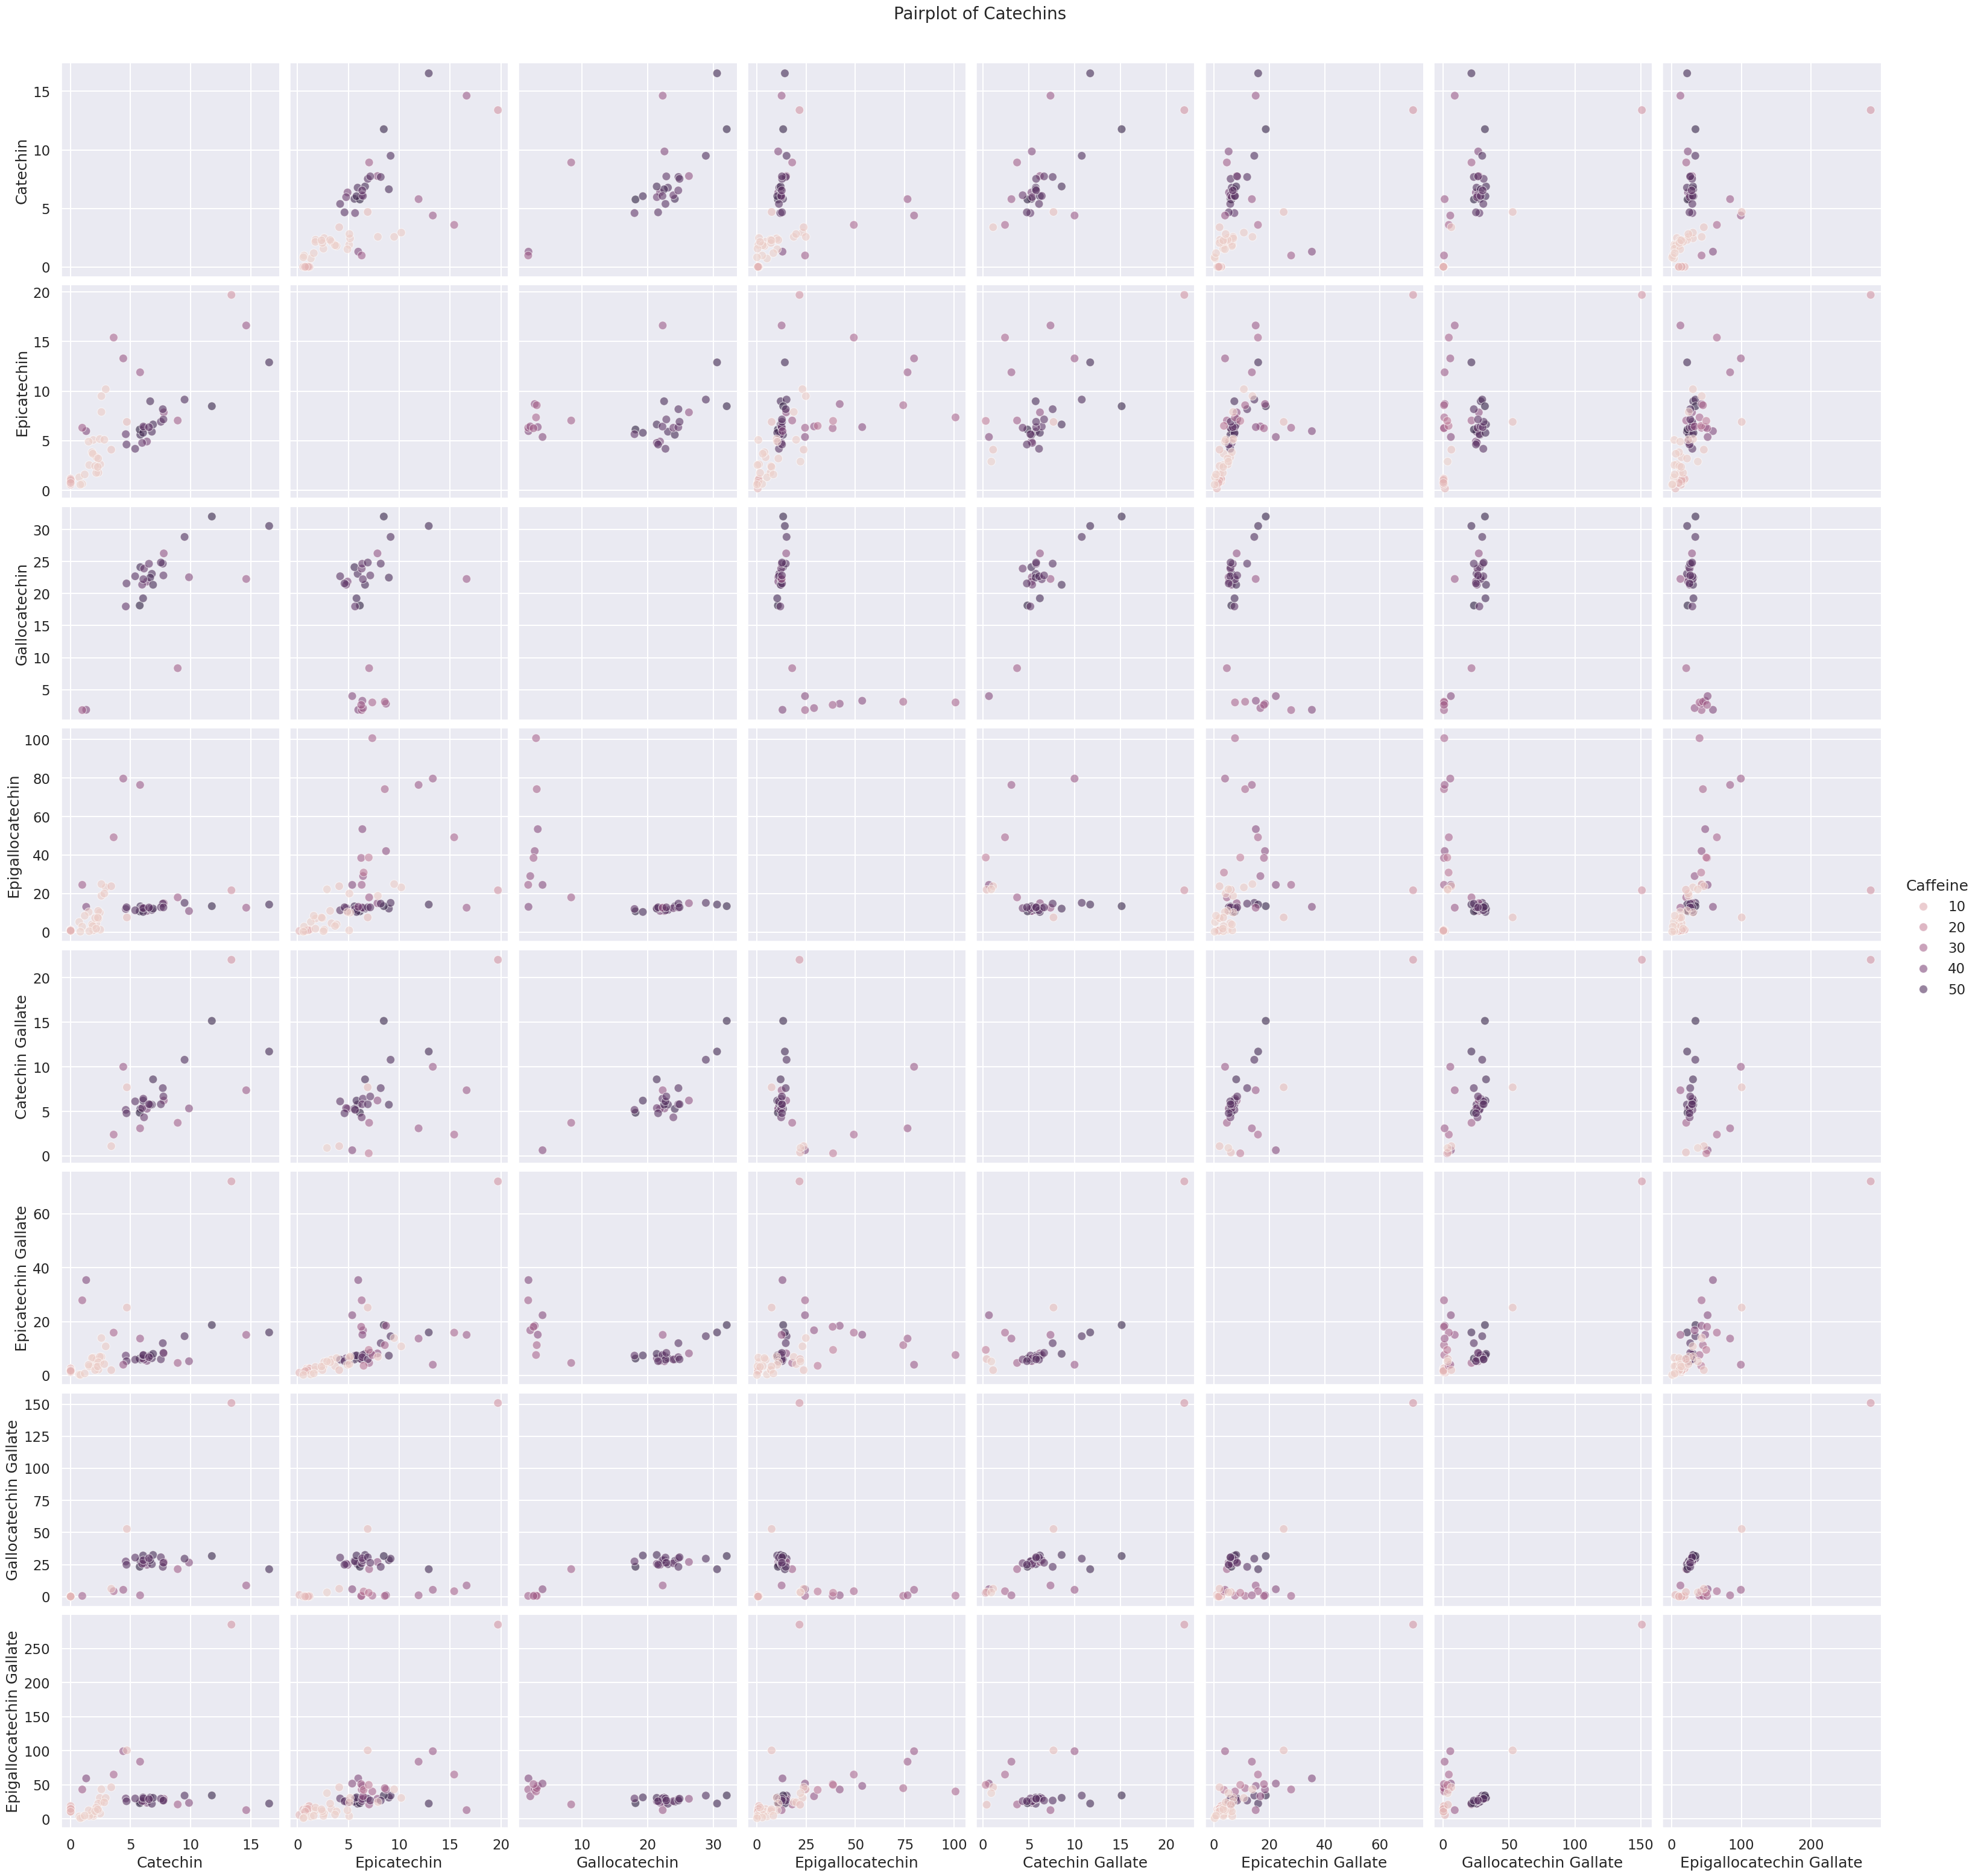

In [45]:
def exploratory_data_analysis():  
    sns.set_theme(style='darkgrid', palette='muted', context='talk')
    plot = sns.pairplot(df, vars=catechins, diag_kind='kde', hue='Caffeine', plot_kws={'alpha': 0.6, 's': 100, 'edgecolor': 'w'}, height=4)
    plot.figure.suptitle("Pairplot of Catechins", size=20)  
    plt.subplots_adjust(top=0.95)  
    plt.show()

exploratory_data_analysis()

# Summary Statistics

The summary statistics of the agggregated data is displayed below. It is interesting to note that there are some significant outliers. One such outlier is Epigallocatechin with a max of aroun 100mg.

In [46]:
df.describe()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
count,88.000000,126.000000,38.000000,140.000000,34.000000,122.000000,96.000000,103.000000,77.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.224205,9.201770,15.676895,15.351629,6.136618,8.033852,11.115458,25.658369,22.670130,24.275000,7.937500,24.545833,8.241667,16.433333
std,3.625484,13.214851,10.256015,19.894685,4.274245,10.327908,19.198973,32.623663,20.182393,1.506291,0.436201,1.601352,0.461488,0.856010
min,0.001000,0.000000,0.000000,0.010000,0.300000,0.070000,0.100000,0.300000,0.558000,22.200000,6.800000,22.200000,7.300000,14.800000
25%,0.020000,1.020000,3.458250,0.837750,4.445000,1.610000,0.260000,8.380000,1.970000,23.325000,7.800000,23.325000,7.950000,15.800000
50%,2.220000,5.325000,21.380000,10.420000,5.755000,5.090000,3.400000,21.110000,16.300000,23.850000,7.950000,24.400000,8.300000,16.400000
75%,5.777500,8.672500,23.017500,22.450000,7.195000,9.852500,23.290000,31.005000,41.080000,25.275000,8.125000,25.875000,8.525000,16.900000
max,16.540000,73.890000,32.020000,100.684000,22.000000,72.000000,150.900000,285.100000,58.830000,27.600000,8.800000,27.600000,8.900000,17.800000


# Training Device

As I am developing on Linux and training on Windows, this code displays if CUDA functionality is being used or not.

In [47]:
# Get cpu, gpu, or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Data Splitting Strategy

In this project, we adopt a unique strategy for dividing our dataset due to the scarcity of available data. We utilize a Kernel Density Estimator to generate synthetic data points based on the original dataset. This synthetic data will form our training set. Meanwhile, the original data points will serve as our testing set. Although this approach may blur the traditional boundaries between training and testing splits, it's important to note that the synthetic training data is entirely separate from the actual test data. This method ensures that we have sufficient data for both effective training and reliable testing.


### The data splitting, imputation, and feature-scaling for this aggregated dataset will be done in four parts:

1. **Chemicals Imputation**:
   - The chemicals will be imputed using sklearn's `SimpleImputer`.

2. **Generation of Additional**:
   - The data we are training on is limited in data. This causes significant overfitting in all machine-learning models. Because of this we will generate synthetic data with `Kernel Density Estimation`. While this isn't perferred it is the best you can do without mass amounts of data. 

3. **Min-Max Scaler**:
   - A `min-max scaler` will be applied so the GAN can learn features correctly.

4. **Sensory Appeals Generation**:
   - The sensory appeals will be generated by a custom `Generative Adversarial Network (GAN)`. The GAN will be trained on the test dataset which contains the sensory values. It will then be used to impute the missing sensory values in the actual training dataset later used for the different models.


# Missing Chemical Imputation with an Iterative Imputer
Note this is causing some negative values that need to be fixed, possibly rows with complete missing data is causing this.

In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=100, verbose=2, random_state=42, imputation_order='random', min_value=[0.02, 1.02, 3.46, 0.84, 4.45, 1.61, 0.26, 8.38, 1.97]) # 25th percentile rounded, may change

df[chemicals] = imputer.fit_transform(df[chemicals])


[IterativeImputer] Completing matrix with shape (145, 9)
[IterativeImputer] Ending imputation round 1/100, elapsed time 0.01
[IterativeImputer] Change: 94.48163221264353, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 2/100, elapsed time 0.01
[IterativeImputer] Change: 26.208309725487563, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 3/100, elapsed time 0.02
[IterativeImputer] Change: 24.60631820383111, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 4/100, elapsed time 0.03
[IterativeImputer] Change: 12.917827402527129, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 5/100, elapsed time 0.03
[IterativeImputer] Change: 16.540535827368455, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 6/100, elapsed time 0.04
[IterativeImputer] Change: 13.979687222047811, scaled tolerance: 0.2851 
[IterativeImputer] Ending imputation round 7/100, elapsed time 0.04
[IterativeImputer] Change: 11.9

/home/tahlon/Documents/Github/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Generation of Additional Data Through Kernel Density Estimation

In [60]:
from sklearn.neighbors import KernelDensity

kde_models = {}

test_df = df.copy()

# Fit KDE models for each column
for column in test_df[chemicals].columns:
    # Extract the numerical data from the column
    train_data = test_df[column].values.reshape(-1, 1)   

    # Fit KDE model for the column
    kde = KernelDensity(bandwidth=0.1)
    kde.fit(train_data)

    # Store the KDE model in the dictionary
    kde_models[column] = kde

generated_data = {}
num_samples = 2000  # Number of new data points to generate

for column, kde_model in kde_models.items():
    generated_data[column] = kde_model.sample(num_samples).reshape(-1)

train_df = np.clip(pd.DataFrame(generated_data), 0, None)
blank_df = pd.DataFrame(columns=standardized_columns)
train_df = pd.concat([blank_df, train_df]).fillna(0)
train_df

/tmp/ipykernel_2254777/2792868513.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([blank_df, train_df]).fillna(0)
/tmp/ipykernel_2254777/2792868513.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = pd.concat([blank_df, train_df]).fillna(0)


,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,2.269994,2.471015,3.635315,76.804463,4.319540,1.610053,0.104702,1.702592,13.507808,0,0,0,0,0
1,2.341722,13.283955,3.239065,10.766115,0.931236,5.694747,0.357674,14.096093,1.884038,0,0,0,0,0
2,5.805102,0.884503,22.975268,17.972234,8.555587,25.153016,6.073362,65.145711,2.203611,0,0,0,0,0
3,3.303903,0.036315,23.223303,32.292790,4.558444,1.107559,0.329482,16.641384,17.792338,0,0,0,0,0
4,3.155872,1.196075,3.413028,0.037116,4.531498,5.347066,11.018763,45.104569,26.287249,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.586995,5.064195,3.472544,14.680700,4.783589,5.069907,27.003707,7.708426,8.920119,0,0,0,0,0
1996,0.002364,6.373973,24.061905,34.696232,4.545179,35.104046,0.160742,12.568800,4.775917,0,0,0,0,0
1997,14.633258,6.157397,21.500767,23.184936,4.603283,1.798504,0.138598,40.141828,8.145243,0,0,0,0,0
1998,0.122313,8.554376,8.354986,0.513785,4.518685,1.688377,0.607155,3.953262,14.173401,0,0,0,0,0


# Scaling Data

In [62]:
# Normalization: Min-Max Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

scaled_train_df = scaler.fit_transform(train_df)
scaled_test_df = scaler.transform(test_df)

scaled_train_df = pd.DataFrame(scaled_train_df, columns=standardized_columns)
scaled_test_df = pd.DataFrame(scaled_test_df, columns=standardized_columns)

In [63]:
scaled_test_df

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,0.535138,0.095168,0.187829,0.178409,0.162704,0.064617,0.142323,0.073526,0.281099,23.1,7.9,23.1,8.1,15.2
1,0.591469,0.053206,0.506643,0.108235,0.236027,0.073353,0.176216,0.081626,0.351420,25.8,8.1,24.9,8.3,16.4
2,0.381728,0.066509,0.491365,0.108830,0.234205,0.075294,0.164433,0.082362,0.368073,23.7,7.8,23.7,7.6,15.8
3,0.406298,0.079892,0.518551,0.113686,0.255610,0.089160,0.167743,0.077138,0.457581,23.7,8.3,24.0,8.6,16.6
4,0.348769,0.075702,0.541917,0.132320,0.233750,0.082366,0.184822,0.087481,0.482288,24.6,8.2,26.4,8.5,16.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.154010,0.401488,0.125369,0.323119,0.195950,0.213756,0.001721,0.156808,0.233921,NaN,NaN,NaN,NaN,NaN
141,0.182774,0.406896,0.145590,0.311225,0.195950,0.208102,0.001721,0.145427,0.243988,NaN,NaN,NaN,NaN,NaN
142,0.168392,0.489356,0.214340,0.285455,0.203887,0.200645,0.001721,0.129334,0.304456,NaN,NaN,NaN,NaN,NaN
143,0.023970,0.012166,0.000000,0.009416,0.195950,0.106906,0.001721,0.057362,0.014114,NaN,NaN,NaN,NaN,NaN


# Legacy Code

This is the code from my initial attempt to split the data, the training did not prove well but I am keeping it around because I spent alot of time on it.

In [52]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2)

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imputer = IterativeImputer(max_iter=100, verbose=2, random_state=42, imputation_order='random', min_value=[0.02, 1.02, 3.46, 0.84, 4.45, 1.61, 0.26, 8.38, 1.97]) # 25th percentile rounded, may change

# train_df[chemicals] = imputer.fit_transform(train_df[chemicals])
# test_df[chemicals] = imputer.transform(test_df[chemicals])

# test_df

# from sklearn.neighbors import KernelDensity

# kde_models = {}

# # Fit KDE models for each column
# for column in train_df[chemicals].columns:
#     # Extract the numerical data from the column
#     train_data = train_df[column].values.reshape(-1, 1)   

#     # Fit KDE model for the column
#     kde = KernelDensity(bandwidth=0.1)
#     kde.fit(train_data)

#     # Store the KDE model in the dictionary
#     kde_models[column] = kde

# # Generate new data points for each column using the respective KDE models
# generated_data = {}
# num_samples = 1000  # Number of new data points to generate

# for column, kde_model in kde_models.items():
#     # Sample from the KDE model to generate new data points
#     generated_data[column] = kde_model.sample(num_samples).reshape(-1)
# train_df = pd.concat([train_df, clipped_data], axis=0)


# Generative Adversarial Network

The purpose of the GAN is to impute missing sensory values. A GAN is a combination of two neural networks: a generator and a discriminator. The generator will generate numbers that it thinks are the appropiate sensory evaluations based on the givens catechins and caffeine input. The discriminator will then decide if that is a realistic output or not. In the end, all missing data on sensory evaluations will be naturally imputted. Much of this was interpreted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html although specifically using GAN not DCGAN.

In [69]:
# Create a training dataset for the GAN (rows that include all sensory scores): 3.93/4.0, Summa Cum Laud
# GAN_train_df = scaled_train_df[(scaled_train_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) # Subset of data containing complete sensory evaluations, right now the GAN does not perform well because of lack of data
# GAN_test_df = scaled_test_df[(scaled_test_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) 

GAN_df = scaled_test_df[(scaled_test_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) 

In [70]:
GAN_df

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,0.535138,0.095168,0.187829,0.178409,0.162704,0.064617,0.142323,0.073526,0.281099,23.1,7.9,23.1,8.1,15.2
1,0.591469,0.053206,0.506643,0.108235,0.236027,0.073353,0.176216,0.081626,0.351420,25.8,8.1,24.9,8.3,16.4
2,0.381728,0.066509,0.491365,0.108830,0.234205,0.075294,0.164433,0.082362,0.368073,23.7,7.8,23.7,7.6,15.8
3,0.406298,0.079892,0.518551,0.113686,0.255610,0.089160,0.167743,0.077138,0.457581,23.7,8.3,24.0,8.6,16.6
4,0.348769,0.075702,0.541917,0.132320,0.233750,0.082366,0.184822,0.087481,0.482288,24.6,8.2,26.4,8.5,16.6
5,0.397908,0.121393,0.505295,0.120724,0.255155,0.102056,0.188727,0.108834,0.469256,24.6,8.1,27.0,8.7,16.8
6,0.345772,0.082866,0.407561,0.106649,0.214167,0.087080,0.154570,0.080153,0.528717,25.2,8.4,24.9,8.4,17.8
7,0.569296,0.123691,0.647964,0.150260,0.484687,0.202032,0.196274,0.119177,0.456223,23.7,7.7,24.3,8.4,15.8
8,0.465624,0.106252,0.590223,0.148377,0.276559,0.113704,0.179063,0.102523,0.318930,23.1,7.3,22.2,8.1,16.0
9,0.276258,0.076513,0.404191,0.118840,0.228740,0.102333,0.181975,0.104241,0.416673,22.2,7.8,22.5,8.0,16.4


In [67]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Layer
            nn.Linear(9, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 5),
            nn.Sigmoid() # This is used because output values are in the range [0, 1) (after scaling of course).
        )


    def forward(self, input):
        output = self.main(input)
        return output

In [56]:
from torch.nn import LayerNorm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            # Input layer with layer normalization and dropout
            nn.Linear(14, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(64), 
            nn.Dropout(0.1),

            # Hidden layers with layer normalization and dropout
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(128),  
            nn.Dropout(0.1),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(256),
            nn.Dropout(0.1),

            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

You must create a custom torch dataset for it to go into the torch dataloader.

In [72]:
# Custom GAN Dataset
from torch.utils.data import Dataset

class GANDataset(Dataset):
    def __init__(self, dataframe):
        self.data_frame = dataframe

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data_frame.iloc[idx]
        sample = torch.tensor(sample.values, dtype=torch.float32)
        return sample

GAN_dataset = GANDataset(GAN_df)

In [73]:
# GAN Dataloader 
from torch.utils.data import DataLoader
dataloader = DataLoader(GAN_dataset, batch_size=16, shuffle=True)

Optimally, I would like to make all of this a reusable pytorch class. There is no hyperparameter searching like grid-search cv in pytorch so I had to do it manually.

In [76]:
# Setup Adam optimizers for both G and D
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# Model Creation
generator = Generator().to(device)
discriminator = Discriminator().to(device)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Layer
            nn.Linear(9, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 5),
            nn.Sigmoid() # This is used because output values are in the range [0, 1) (after scaling of course).
        )


    def forward(self, input):
        output = self.main(input)
        return output

from torch.nn import LayerNorm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            # Input layer with layer normalization and dropout
            nn.Linear(14, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(64), 
            nn.Dropout(0.1),

            # Hidden layers with layer normalization and dropout
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(128),  
            nn.Dropout(0.1),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(256),
            nn.Dropout(0.1),

            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

# Custom GAN Dataset
from torch.utils.data import Dataset

class GANDataset(Dataset):
    def __init__(self, dataframe):
        self.data_frame = dataframe

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data_frame.iloc[idx]
        sample = torch.tensor(sample.values, dtype=torch.float32)
        return sample

GAN_dataset = GANDataset(GAN_df)


# Optimizer Creation
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Initialize the BCELoss function
criterion = nn.BCELoss() # Standard for GAN's
generator_losses = []
discriminator_losses = []

def train_GAN(epochs):
    max_grad_norm = 1.0  # Maximum gradient norm threshold
    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):
            
            # Seperate data and convert to current device
            chemical_data, sensory_data = data[:, :9].to(device), data[:, 9:].to(device)

            # Find current batch size
            current_batch_size = chemical_data.size(0)

            # Create labels for real and generated data
            real_label = torch.full((current_batch_size,), .9, dtype=torch.float, device=device) # Creates a tensor of labels indiciated data is real w/ label smoothing
            fake_label = torch.full((current_batch_size,), .1, dtype=torch.float, device=device) # Creates a tensor of labels indidicated data is generated, very unconventional, initially a mistake

            # Update Discriminator - Clear accumulated gradients from previous pass
            discriminator.zero_grad()

            # Train discriminator with real data w/ some notes for myself
            real_data = torch.cat((chemical_data, sensory_data), 1) # Same as pd.concat(axis=1)
            output = discriminator(real_data).view(-1) # Same as numpy.reshape(-1,1), used to calculate loss
            errD_real = criterion(output, real_label)
            errD_real.backward() # Perform backpropogation based on errD_real
            D_x = output.mean().item() # Outputs average discriminator prediction

            # Train discriminator with fake data
            fake_sensory_data = generator(chemical_data) 
            fake_data = torch.cat((chemical_data, fake_sensory_data), 1) # Create a dataset of real chemical data but generated sensory data
            output = discriminator(fake_data.detach()).view(-1) # detach is used to ensure gradients aren't computed for the generator during the discriminators backwards pass
            errD_fake = criterion(output, fake_label)
            errD_fake.backward()
            D_G_z1 = output.mean().item() # Outputs average discriminator prediction for fake data

            # Apply gradient clipping to discriminator
            clip_grad_norm_(discriminator.parameters(), max_grad_norm)

            # Update Discriminator weights
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update Generator
            generator.zero_grad()
            output = discriminator(fake_data).view(-1)
            errG = criterion(output, real_label)
            errG.backward()
            D_G_z2 = output.mean().item()

            # Apply gradient clipping to generator
            clip_grad_norm_(generator.parameters(), max_grad_norm)

            # Update Generate weights
            optimizerG.step()

            # Print training log
            if i % 50 == 0: # Prints every 50 batches, might change
                print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] '
                    f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                    f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
                
            # Save losses
            generator_losses.append(errG.item())
            discriminator_losses.append(errD.item())

train_GAN(300)

[0/300][0/2] Loss_D: 1.4195 Loss_G: 0.8166 D(x): 0.5252 D(G(z)): 0.5225 / 0.4449
[1/300][0/2] Loss_D: 1.1171 Loss_G: 1.0197 D(x): 0.6397 D(G(z)): 0.4277 / 0.3453
[2/300][0/2] Loss_D: 0.9417 Loss_G: 1.3104 D(x): 0.7062 D(G(z)): 0.3403 / 0.2555
[3/300][0/2] Loss_D: 0.8039 Loss_G: 1.3871 D(x): 0.8062 D(G(z)): 0.2883 / 0.2285
[4/300][0/2] Loss_D: 0.6954 Loss_G: 1.8077 D(x): 0.8420 D(G(z)): 0.1599 / 0.1468
[5/300][0/2] Loss_D: 0.6909 Loss_G: 2.1401 D(x): 0.8747 D(G(z)): 0.1728 / 0.1052
[6/300][0/2] Loss_D: 0.6865 Loss_G: 2.3591 D(x): 0.8937 D(G(z)): 0.1021 / 0.0866
[7/300][0/2] Loss_D: 0.6669 Loss_G: 2.2114 D(x): 0.8941 D(G(z)): 0.0824 / 0.0911
[8/300][0/2] Loss_D: 0.6762 Loss_G: 2.1622 D(x): 0.9114 D(G(z)): 0.1113 / 0.1008
[9/300][0/2] Loss_D: 0.6653 Loss_G: 2.0406 D(x): 0.8891 D(G(z)): 0.0890 / 0.1103
[10/300][0/2] Loss_D: 0.6694 Loss_G: 2.0622 D(x): 0.9135 D(G(z)): 0.1199 / 0.1080
[11/300][0/2] Loss_D: 0.6673 Loss_G: 2.1823 D(x): 0.8707 D(G(z)): 0.0986 / 0.0949
[12/300][0/2] Loss_D: 0.67

Notes: The best thing I did to for training is label smoothing.

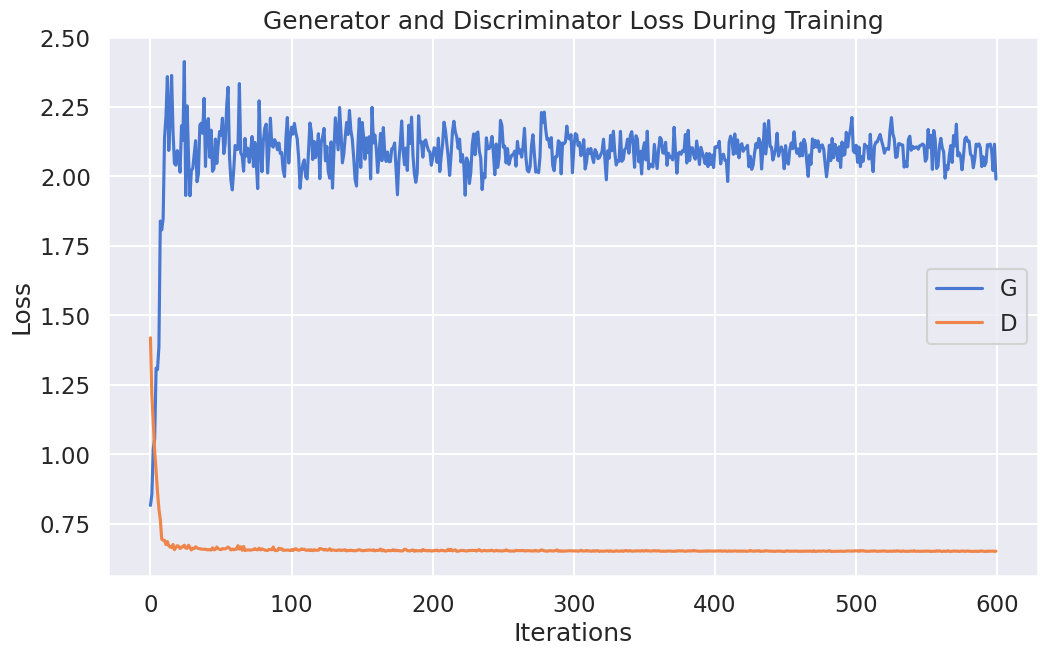

In [77]:
def plot_GAN_loss():
    plt.figure(figsize=(12,7))
    plt.title('Generator and Discriminator Loss During Training')
    plt.plot(generator_losses, label='G')
    plt.plot(discriminator_losses, label='D')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

plot_GAN_loss()

# Define rows that need to be imputed
These are the rows currently missing sensory data

In [78]:
train_data_to_impute = torch.tensor(scaled_train_df[(scaled_train_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values, dtype=torch.float32).to(device)
test_data_to_impute = torch.tensor(scaled_test_df[(scaled_test_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values, dtype=torch.float32).to(device)

# Impute missing sensory data with the GAN

In [83]:
generator.eval() # Put generator in eval mode

with torch.no_grad():
    imputed_sensory_data_train = pd.DataFrame(generator(train_data_to_impute).cpu().numpy(), columns=sensory_evaluations)
    imputed_sensory_data_test = pd.DataFrame(generator(test_data_to_impute).cpu().numpy(), columns=sensory_evaluations)

In [82]:
pd.DataFrame(test_data_to_impute.cpu(), columns=chemicals)

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine
0,0.078803,0.080703,0.041880,0.129783,0.195950,0.490798,0.069681,0.207617,0.356163
1,0.059207,0.085299,0.040981,0.243053,0.195950,0.386773,0.004170,0.150522,0.285832
2,0.291508,0.117608,0.063224,0.416913,0.195950,0.255737,0.007527,0.150473,0.324179
3,0.178335,0.087097,0.047968,0.288131,0.195950,0.232594,0.001721,0.115573,0.310386
4,0.963376,0.099385,0.067740,0.997942,0.317767,0.105370,0.005574,0.140323,0.260844
...,...,...,...,...,...,...,...,...,...
116,0.154010,0.401488,0.125369,0.323119,0.195950,0.213756,0.001721,0.156808,0.233921
117,0.182774,0.406896,0.145590,0.311225,0.195950,0.208102,0.001721,0.145427,0.243988
118,0.168392,0.489356,0.214340,0.285455,0.203887,0.200645,0.001721,0.129334,0.304456
119,0.023970,0.012166,0.000000,0.009416,0.195950,0.106906,0.001721,0.057362,0.014114


# Concatenate imputed values to host dataframe

In [81]:
imputed_train_df = pd.concat([pd.DataFrame(train_data_to_impute.cpu()), pd.DataFrame(imputed_sensory_data_train)], axis=1).set_axis(standardized_columns, axis='columns')
imputed_test_df = pd.concat([pd.DataFrame(test_data_to_impute.cpu()), pd.DataFrame(imputed_sensory_data_test)], axis=1).set_axis(standardized_columns, axis='columns')

train_df = pd.concat([scaled_train_df, imputed_train_df], axis=0)
test_df = pd.concat([GAN_df, imputed_test_df], axis=0)

ValueError: Length mismatch: Expected axis has 5 elements, new values have 14 elements

In [ ]:
train_df

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
1,0.390222,0.007226,0.058936,0.132459,0.036956,0.026181,0.527094,0.248116,0.057855,0.444444,0.700000,0.777778,0.750000,0.600000
5,0.361391,0.005406,0.055467,0.112119,0.043261,0.025872,0.575612,0.295638,0.052122,0.222222,0.400000,0.277778,0.250000,0.400000
6,0.411007,0.008142,0.058399,0.123132,0.029827,0.026181,0.492168,0.257182,0.047531,0.055556,0.500000,0.111111,0.125000,0.266667
14,0.598743,0.009084,0.020427,0.178596,0.025249,0.020539,0.405892,0.208465,0.033671,0.166667,0.550000,0.166667,0.500000,0.133333
21,0.518955,0.009226,0.055784,0.127101,0.047388,0.036935,0.499342,0.265750,0.050740,0.388889,0.550000,0.425926,0.562500,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.076589,0.007764,0.020462,0.000000,0.036281,0.035053,0.007904,0.303473,0.008278,0.999924,0.999823,0.999915,0.999801,0.982352
1092,0.046061,0.033618,0.011042,0.011967,0.062909,0.049011,0.002986,0.373904,0.035591,0.999989,0.999954,0.999986,0.999892,0.993843
1093,0.364457,0.010798,0.060044,0.000157,0.005988,0.021587,0.535194,0.427265,0.051846,0.206889,0.986539,0.945375,0.910470,0.746565
1094,0.444677,0.001326,0.008548,0.000247,0.037565,0.043848,0.039898,0.112580,0.035355,0.969744,0.967283,0.887092,0.792883,0.696065


# Feature Engineering

A derived feature called overall score will be produced from all sensory scores so the models only have to predict a single response.

In [ ]:
# Derived Feature: Overall Sensory Score
def compute_sensory_score(df):
    df['Overall Sensory Score'] = df['Taste'] + df['Appearance'] + df['Aroma'] + df['Liqour color'] + df['Infused leaf']
    df = df.drop(columns=['Taste','Appearance','Aroma','Liqour color','Infused leaf'])
    return df

train_df = compute_sensory_score(train_df)
test_df = compute_sensory_score(test_df)


# PCA (Principal Component Analysis)

Because the high-dimensional nature of the data, PCA will be used to display the number of features.

In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=9, random_state=42)

train_df_pca = train_df.copy()
test_df_pca = test_df.copy()

train_X_pca = kpca.fit_transform(train_df_pca.drop(columns=['Overall Sensory Score']))
test_X_pca = kpca.transform(test_df_pca.drop(columns=['Overall Sensory Score']))

train_y_pca = train_df_pca[['Overall Sensory Score']]
test_y_pca = test_df_pca[['Overall Sensory Score']]

# https://stackoverflow.com/questions/29611842/scikit-learn-kernel-pca-explained-variancepca.explained_variance_
explained_variance = np.var(train_X_pca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
exp_var_cumul = np.cumsum(explained_variance_ratio)

In [ ]:
# Prepare data for Torch-based models
train_X = train_df.drop(columns=['Overall Sensory Score'])
test_X = test_df.drop(columns=['Overall Sensory Score'])

train_y = train_df[['Overall Sensory Score']]
test_y = test_df[['Overall Sensory Score']]

train_X_tensor = torch.tensor(train_X.values, dtype=torch.float64).float()
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float64).float()
test_X_tensor = torch.tensor(test_X.values, dtype=torch.float64).float()

In [ ]:
import plotly.express as px

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

# Random Forest

Pytorch does not have a built in Random Forest class, instead we will use scikit learn's implementation. 

In [ ]:
# Model Creation
from sklearn.ensemble import RandomForestRegressor

GridSearchCV_random_forest = RandomForestRegressor()

In [ ]:
# Hyperparameter Selection
# from sklearn.model_selection import GridSearchCV

# parameters_random_forest = {
#     'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#     'max_depth': [int(x) for x in np.linspace(start=1, stop=6, num=6)],
#     'min_samples_split': [int(x) for x in np.linspace(start=1, stop=6, num=6)],
#     'random_state': [42]
# }

# clf_random_forest = GridSearchCV(GridSearchCV_random_forest, parameters_random_forest)
# clf_random_forest.fit(train_X, train_y.values.ravel())

In [ ]:
# clf_random_forest.best_params_

In [ ]:
# Model Training
from sklearn.metrics import mean_squared_error

Model_Random_Forest = RandomForestRegressor(max_depth=6, min_samples_split=3, n_estimators=100, random_state=42)
Model_Random_Forest.fit(train_X, train_y.values.ravel())
y_pred_random_forest = Model_Random_Forest.predict(test_X)
random_forest_mse = mean_squared_error(test_y, y_pred_random_forest)
random_forest_mse

0.09210370412184125

# Multilayer Perceptron
This multilayer perceptron outputs a overall sensory score based on input chemicals.

notes: I ultimately want someone to put in a tea and see if it is generally likeable. This returns the scaled score so I need to return that scaled score into an interpretable one. Next I need to see how I would integrate this model into an interactie web app. Think about that...

In [ ]:
# Model Creation
class MLP(nn.Module):
    def __init__(self):
        super().__init__()  
        self.main = nn.Sequential(
            # First Layer
            nn.Linear(9, 16),
            nn.ReLU(),

            # Second Layer
            nn.Linear(16, 32),
            nn.ReLU(),

            # Output Layer
            nn.Linear(32, 1),
            nn.ReLU() # Used because the output is greater than 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
# Training Loop Creation - very rough creation
def train_MLP(model, X, y, learning_rate=0.1, n_epochs=100):
    losses = []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    for epoch in range(n_epochs):
        model.train()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print(f'[{epoch}/{n_epochs}]',
            f'Loss: {loss.item():.4f}')
                 
        losses.append(loss.item())

def predict_MLP(model, X):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        X = X.to(device)
        predictions = model(X)
    return predictions

In [ ]:
# Model Training
Model_MLP = MLP()
train_MLP(Model_MLP, train_X_tensor, train_y_tensor) 

[0/100] Loss: 22.6070
[10/100] Loss: 0.3962
[20/100] Loss: 0.3201
[30/100] Loss: 0.5427
[40/100] Loss: 0.3195
[50/100] Loss: 0.1901
[60/100] Loss: 0.2021
[70/100] Loss: 0.1867
[80/100] Loss: 0.2108
[90/100] Loss: 0.1889


In [ ]:
# Model Predictions
y_pred_mlp = predict_MLP(Model_MLP, test_X_tensor)
y_pred_mlp = y_pred_mlp.detach()

In [ ]:
# Model Evaluation
mse_mlp = mean_squared_error(test_y, y_pred_mlp)
mse_mlp

0.15019181941127802

# Recurrent Neural Network

In [ ]:
# Model Creation - https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
class RNN(nn.Module):
    def __init__(self, input_size=9, output_size=1, hidden_dim=12, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fully_connected = nn.Linear(hidden_dim, output_size)

    def forward(self, X):
        batch_size = X.size(0)
        hidden = self.init_hidden(batch_size, X.device)       
        out, hidden = self.rnn(X, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fully_connected(out)
        return out, hidden
        
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        return hidden
    
def predict_RNN(model, X):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        X = X.to(device)
        predictions = model(X)
    return predictions

In [ ]:
# Training Loop Creation - very rough creation
def train_RNN(model, X, y, learning_rate=0.1, n_epochs=100):
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output, hidden = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print(f'[{epoch}/{n_epochs}]',
            f'Loss_D: {loss.item():.4f}')
                 
        losses.append(loss.item())


In [ ]:
# Model Training
Model_RNN = RNN()
train_RNN(Model_RNN, train_X_tensor.unsqueeze(0), train_y_tensor) # Unsqueeze because RNN expects inputs with the shape (batch_size, seq_length, features)

[0/100] Loss_D: 23.8612


[10/100] Loss_D: 0.6682
[20/100] Loss_D: 0.4442
[30/100] Loss_D: 0.5291
[40/100] Loss_D: 0.4542
[50/100] Loss_D: 0.4012
[60/100] Loss_D: 0.4094
[70/100] Loss_D: 0.4013
[80/100] Loss_D: 0.4023
[90/100] Loss_D: 0.4012


In [ ]:
# Model Predictions
y_pred_rnn, hidden_rnn = predict_RNN(Model_RNN, test_X_tensor.unsqueeze(0))
y_pred_rnn = y_pred_rnn.detach()

In [ ]:
# Model Evaluation
mse_rnn = mean_squared_error(test_y, y_pred_rnn)
mse_rnn

0.3924733759079688

# Model Visualization and Comparison
https://neptune.ai/blog/deep-learning-visualization

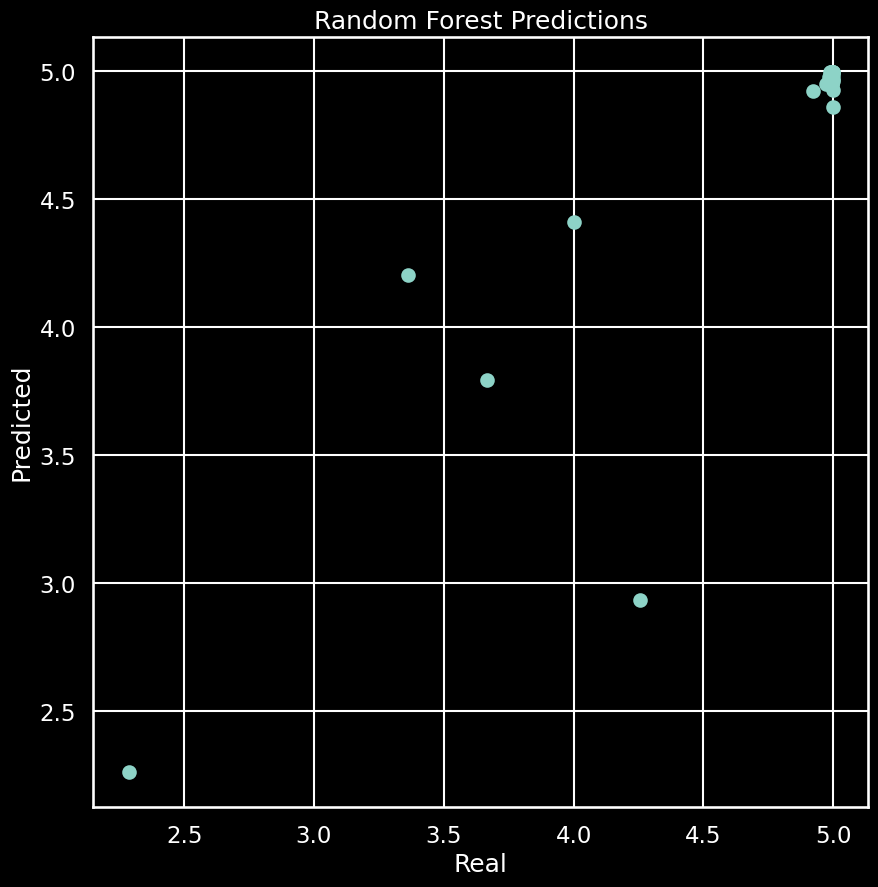

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Random Forest Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_random_forest)
plt.show()

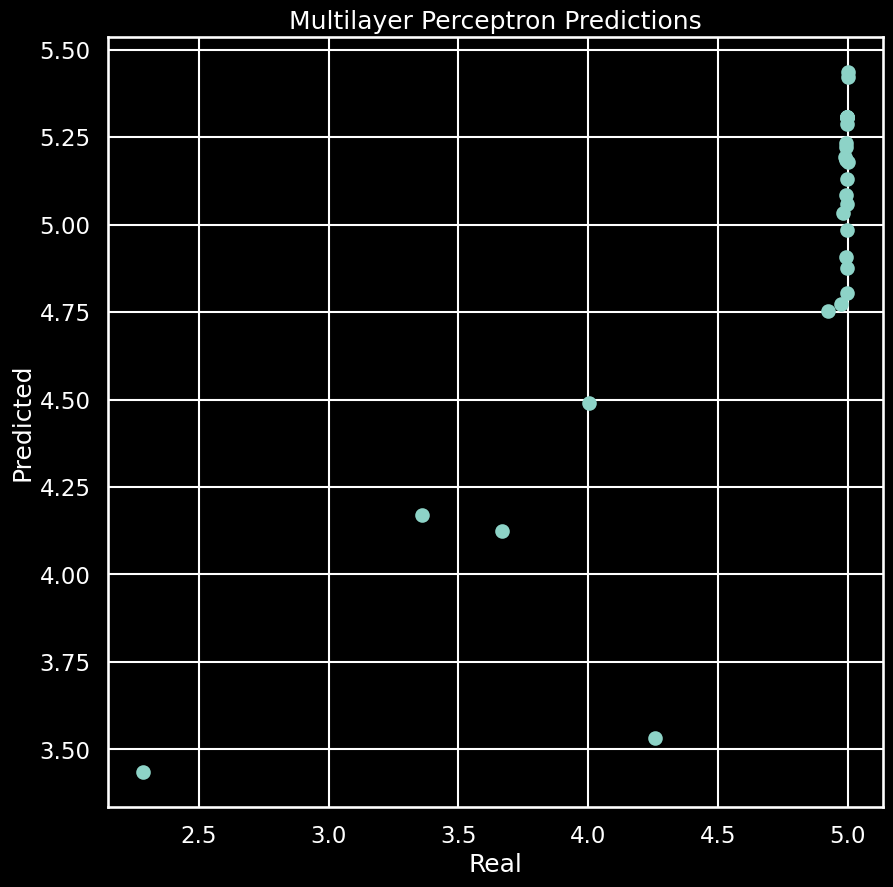

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Multilayer Perceptron Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_mlp)
plt.show()

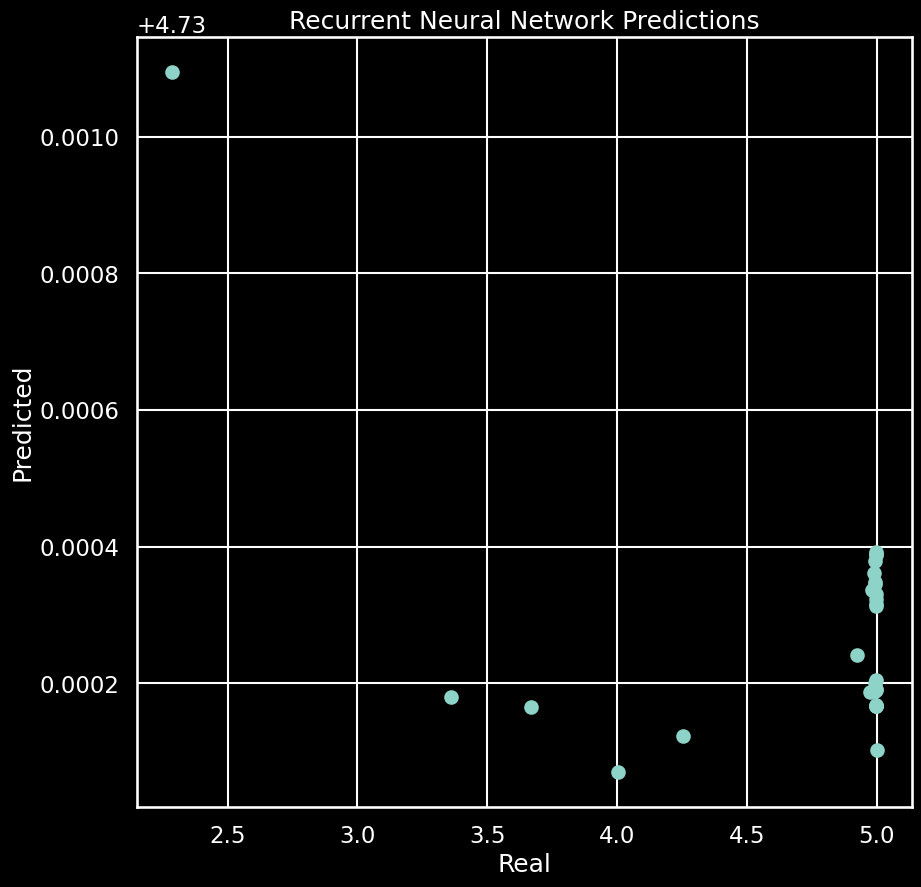

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Recurrent Neural Network Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_rnn)
plt.show()

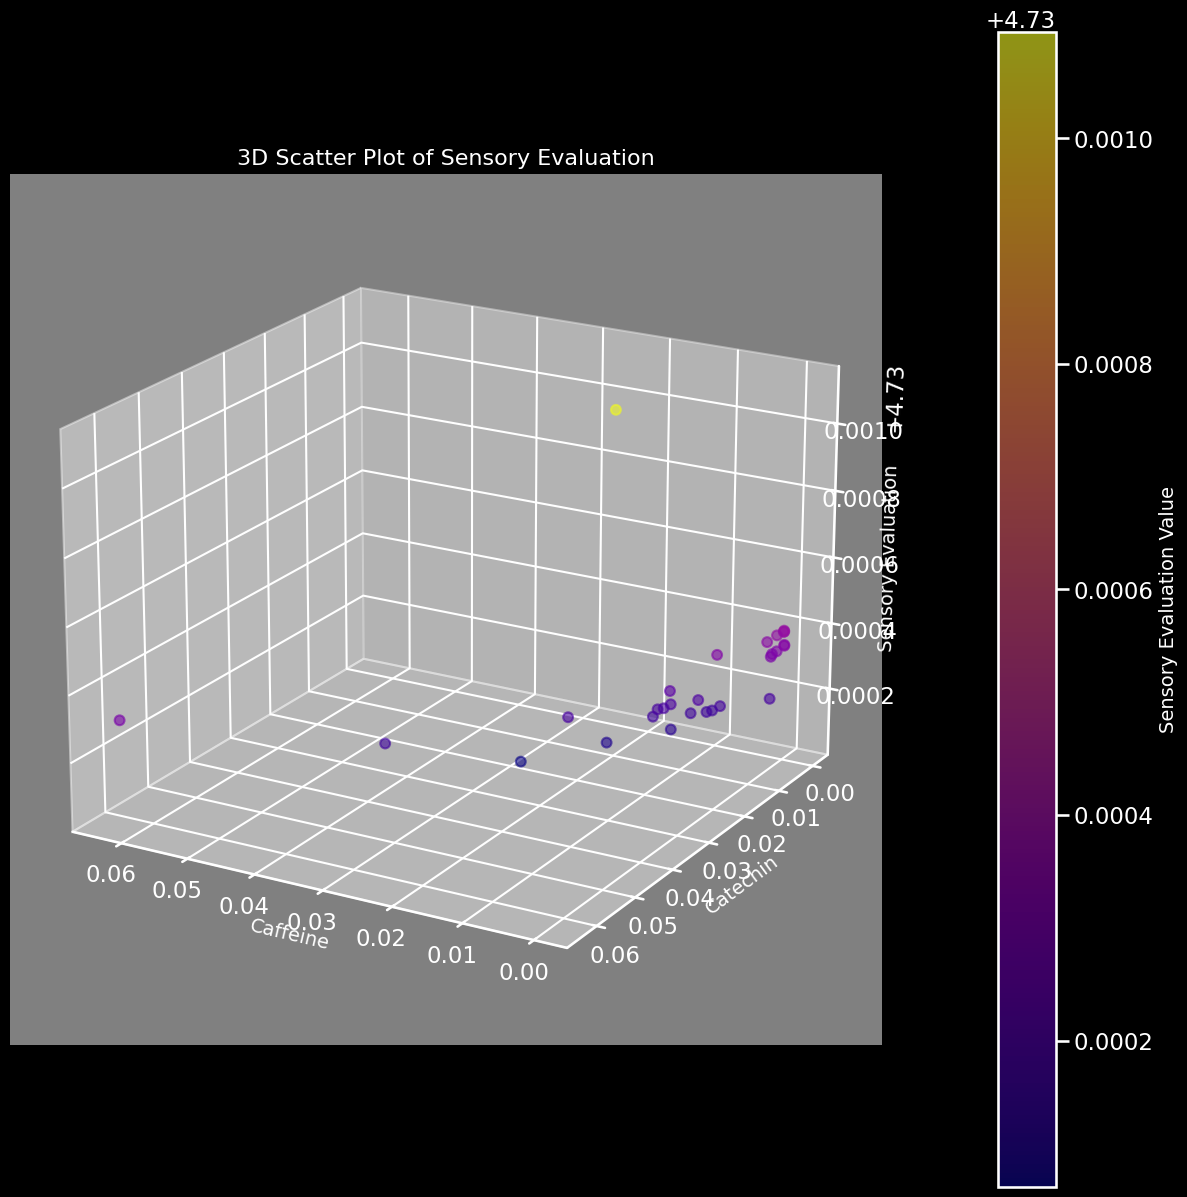

In [ ]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d', facecolor='gray')
scatter = ax.scatter(test_X.iloc[:len(y_pred_rnn), 1], test_X.iloc[:len(y_pred_rnn), 1], y_pred_rnn, c=y_pred_rnn, cmap='plasma', s=50, alpha=0.6)
ax.set_xlabel('Caffeine', fontsize=14, color='white')
ax.set_ylabel('Catechin', fontsize=14, color='white')
ax.set_zlabel('Sensory Evaluation', fontsize=14, color='white')
ax.set_title('3D Scatter Plot of Sensory Evaluation', fontsize=16, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.view_init(elev=20, azim=120)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sensory Evaluation Value', fontsize=14, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
plt.show()

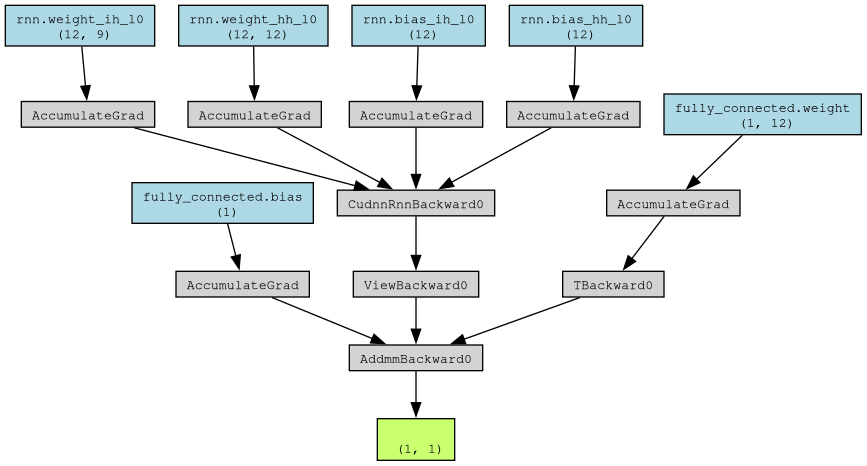

In [ ]:
from torchviz import make_dot

# Set model to evaluation mode and set it to current device
Model_RNN.eval().to(device)

# Create a dummy input tensor that matches the model's expected input dimensions
dummy_input = torch.randn(1, 1, 9).to(device) 

# Perform a forward pass through the model with dummy input to get the output
output, _ = Model_RNN(dummy_input.to(device))

# Generate the visualization using the output tensor
dot = make_dot(output, params=dict(Model_RNN.named_parameters()))

# Render and save the visualization to a file
dot.render("RNNModelVisualization", format="png")

from IPython.display import Image

Image('RNNModelVisualization.png')

# Export model

This model will be implemented in Python and made accessible through a REST API using Flask. Subsequently, the Flask application will be hosted on a Linux server utilizing Gunicorn for deployment. The ONNX standard is being adopted for this model.

In [ ]:
import torch.onnx

def save_model_as_onnx(model, model_name, dummy_input):
    model.eval()
    torch.onnx.export(model,               # seleced model
                      dummy_input,         # model input 
                      f"{model_name}.onnx",  # where to save the model
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=10,    # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['input'],   # the model's input names
                      output_names=['output'],  # the model's output names
                      dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                                    'output': {0: 'batch_size'}})
    
# Converting non-PyTorch models to ONNX format requires using the skl2onnx library.
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Convert the sklearn model with skl2onnx
initial_type = [('float_input', FloatTensorType([None, train_X.shape[1]]))]  # FloatTensorType means it can accept any number of rows by two features
onnx_model = convert_sklearn(Model_Random_Forest, initial_types=initial_type)

# Save the model
with open("Model_RF.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

dummy_input_mlp = torch.randn(1, train_X.shape[1])  
save_model_as_onnx(Model_MLP, "Model_MLP", dummy_input_mlp)

device = next(Model_RNN.parameters()).device
dummy_input_rnn = torch.randn(1, list(train_X_tensor.unsqueeze(0).shape)[1], list(train_X_tensor.unsqueeze(0).shape)[2])  
dummy_input_rnn = dummy_input_rnn.to(device)
save_model_as_onnx(Model_RNN, "Model_RNN", dummy_input_rnn)



/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/torch/onnx/symbolic_opset9.py:4662: UserWarning:

Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 

